In [62]:
# ----------------------------------------------------------------------------
#
# TITLE - 1D_radial_DF_model.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Look at some of the model calculated triaxial DFs
'''

__author__ = "James Lane"

In [63]:
## Imports

## Basic
import numpy as np
import sys, os, pdb, glob
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier

In [64]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Functions

In [65]:
# Define the sinusoid fitting function:
def sinusoid(x,A,om,phase,D):
    return A*np.cos(om*x + phase) + D
#def

## Keywords and File Names

In [66]:
bar_file_base = '../../scripts/generate_bar_triaxial_df/2019-02-24/output/data_'
bar_file_specs = ['b090.npy','b095.npy','b105.npy','b110.npy']
bar_files = [ bar_file_base+spec for spec in bar_file_specs ]
bar_label = 'Triaxial halo + bar'

trihalo_file_base = './data/results_b'
trihalo_file_specs = ['90.npy','95.npy','105.npy','110.npy']
trihalo_files = [ trihalo_file_base+spec for spec in trihalo_file_specs ]
trihalo_label = 'Triaxial halo'

assert len(bar_files) == len(trihalo_files)
b_values = [0.9,0.95,1.05,1.1]
n_files = len(bar_files)

In [67]:
# Check radial ranges
bar_data_tmp = np.load(bar_files[0]).astype(float)
trihalo_data_tmp = np.load(trihalo_files[0]).astype(float)

bar_R_range = np.sort( np.unique(bar_data_tmp[:,0]).astype(float) )
trihalo_R_range = np.sort( np.unique(trihalo_data_tmp[:,0]).astype(float) )

assert np.array_equal(bar_R_range, trihalo_R_range)
print(bar_R_range)
print(trihalo_R_range)

n_R = len(bar_R_range)
R_range = np.array(bar_R_range)

[ 5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5]
[ 5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5]


In [68]:
# Check phi ranges
bar_phi_range = [ np.min( bar_data_tmp[:,1] ), np.max( bar_data_tmp[:,1] ) ]
trihalo_phi_range = [ np.min( trihalo_data_tmp[:,1] ), np.max( trihalo_data_tmp[:,1] ) ]
print(bar_phi_range)
print(trihalo_phi_range)

[-3.1363636363636362, 3.1363636363636362]
[-1.5555555555555556, 1.5555555555555556]


In [75]:
sim_bar_only_data = np.load('../../scripts/generate_bar_df/2019-03-11/data.npy').astype(float)

Triaxial halo DF-inferred velocities only go from $-\pi/2$ to $\pi/2$. Bar does the full range. Flip the triaxial halo about its axis when in use.

# Plot tangential velocity

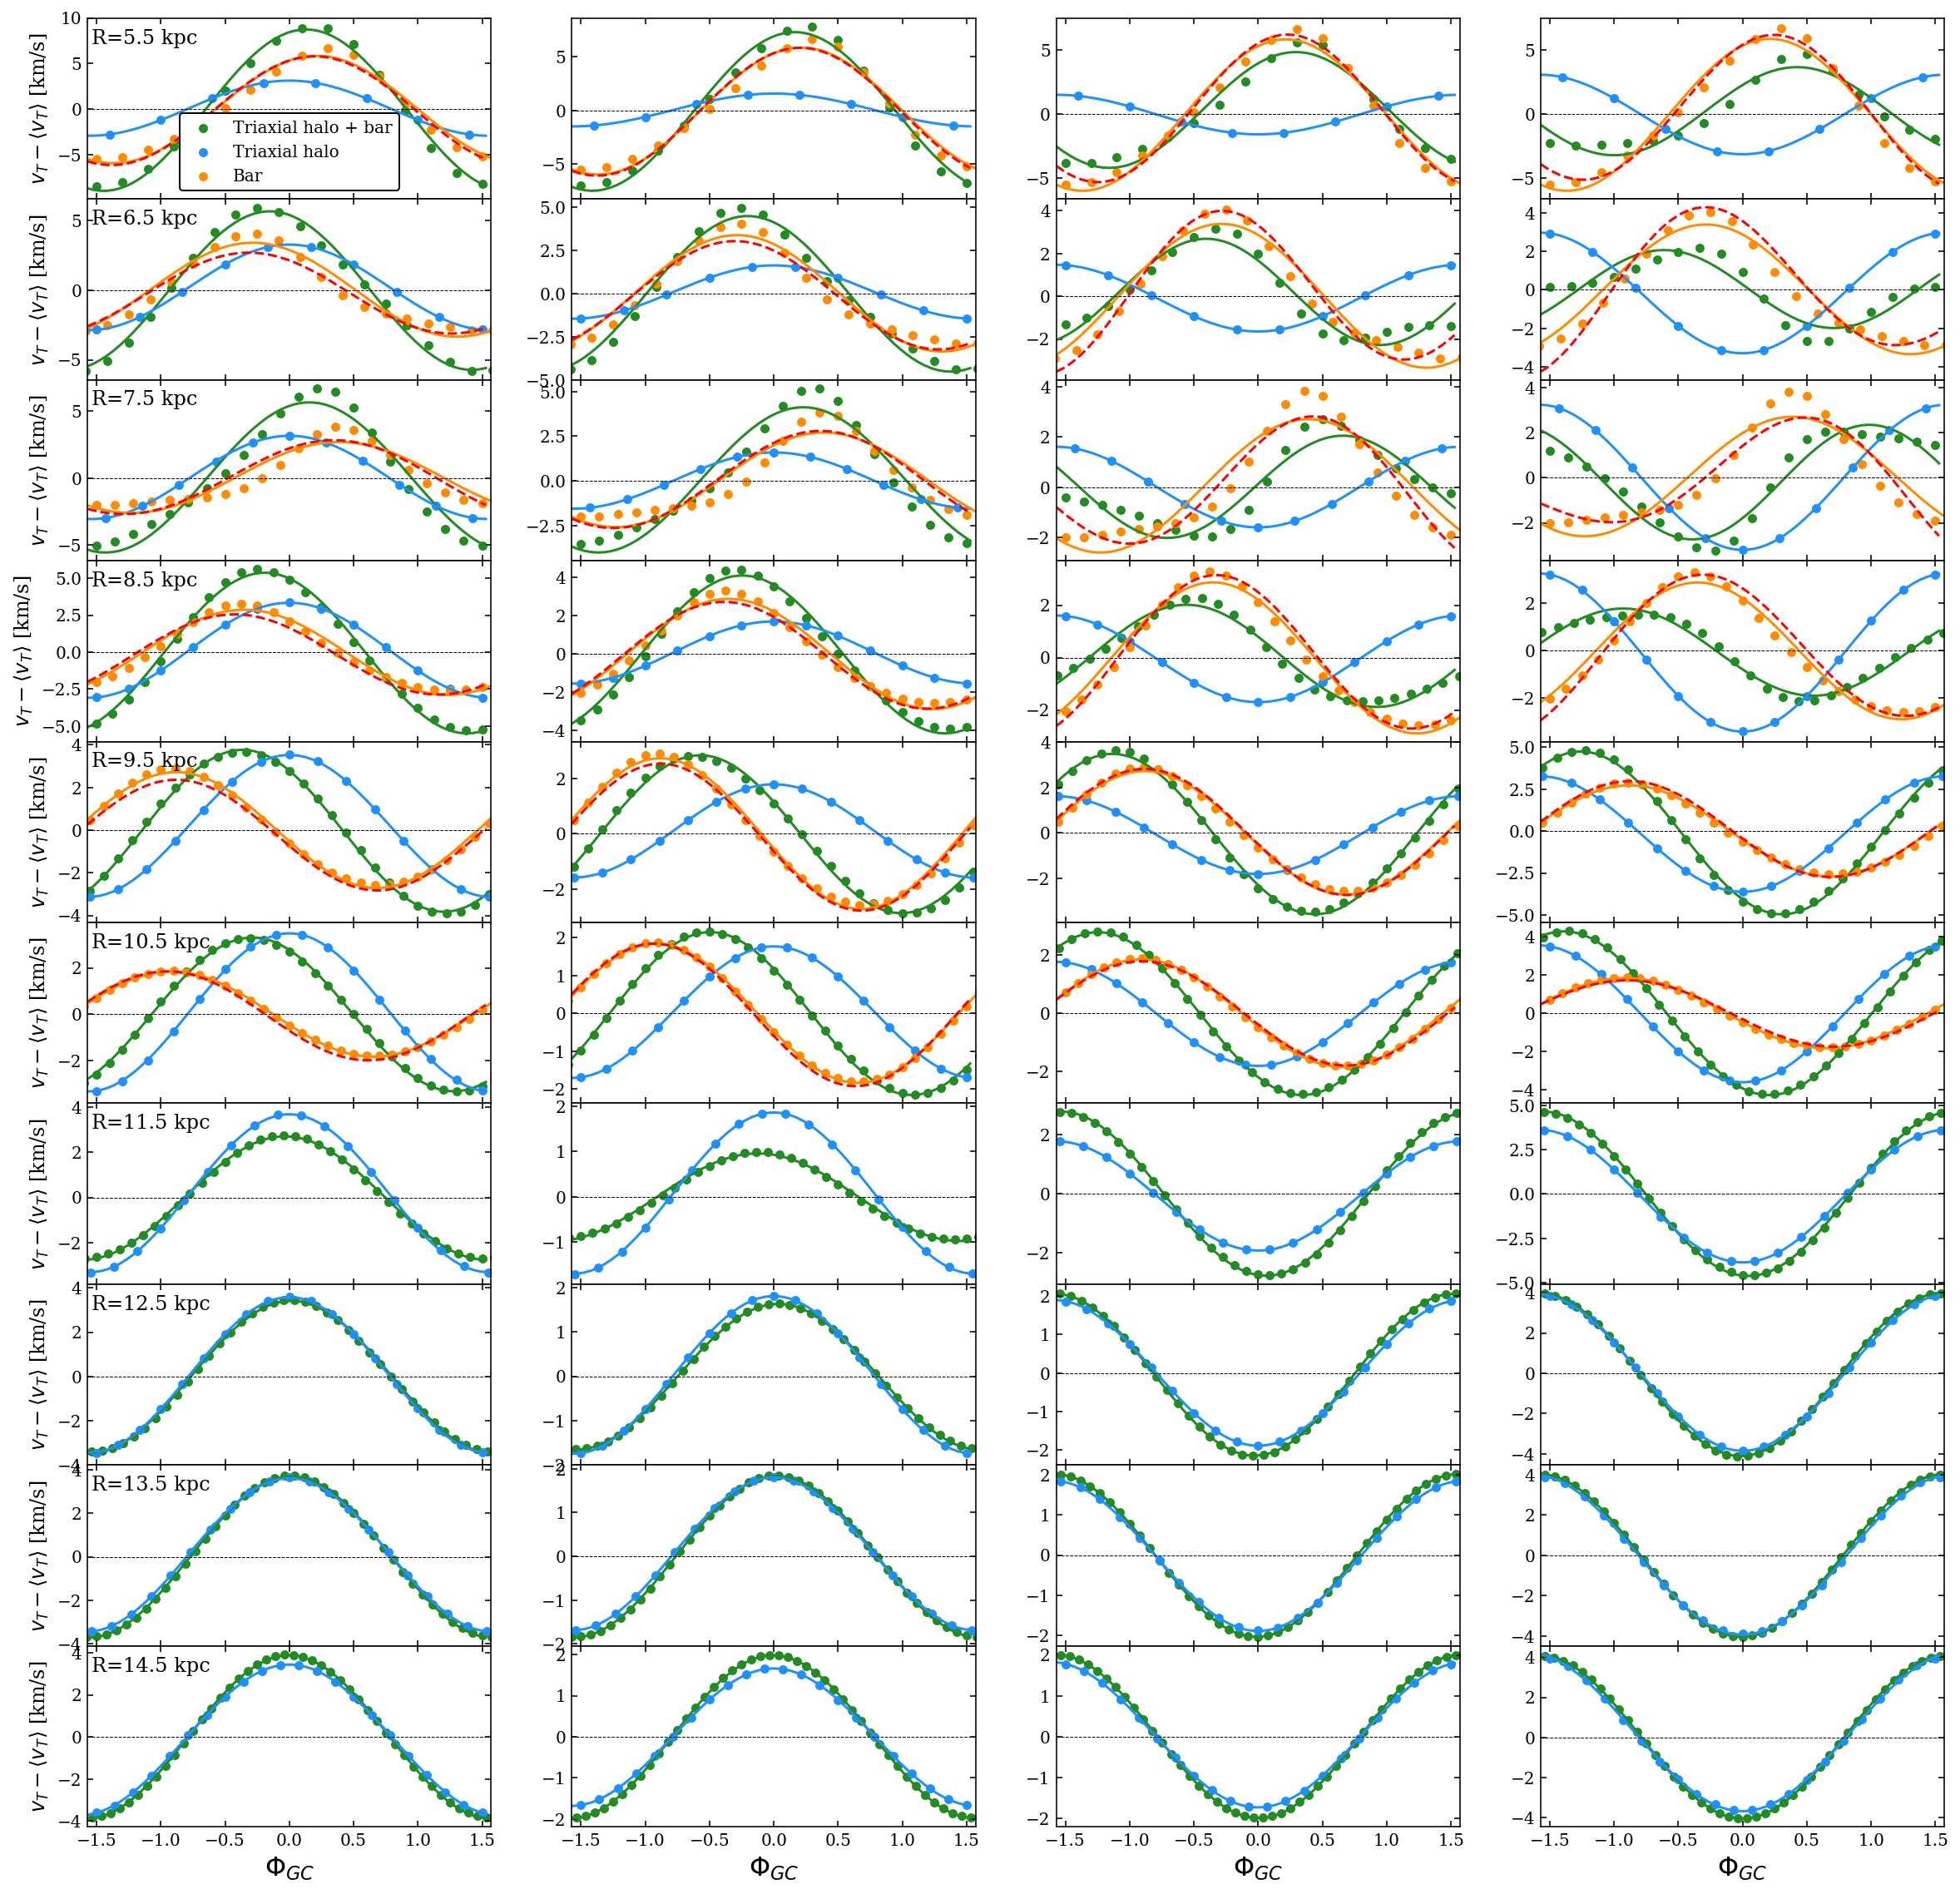

In [80]:
# Make the figure. 4 columns of axes, one for each radial bin.
fig = plt.figure( figsize=(20,int(n_R*2) ) )
axs = fig.subplots( nrows=n_R, ncols=4 )

# Read in just the bar data


# Now loop over each b value
for i in range( n_files ):
    
    # Load the data
    sim_bar_data = np.load( bar_files[i] ).astype(float)
    sim_halo_data = np.load( trihalo_files[i] ).astype(float)
    
    # Loop over each radial bin
    for j in range( n_R ):
        
        # Load data
        where_current_R_bar = np.where( sim_bar_data[:,0] == R_range[j] )[0]
        where_current_R_halo = np.where( sim_halo_data[:,0] == R_range[j] )[0]
        
        # Get the velocity and angle
        sim_bar_v = sim_bar_data[ where_current_R_bar, 6 ]
        sim_bar_v -= np.mean(sim_bar_v)
        sim_bar_phi = sim_bar_data[ where_current_R_bar, 1 ]
        sim_halo_v = sim_halo_data[ where_current_R_halo, 6 ]
        sim_halo_v -= np.mean(sim_halo_v)
        sim_halo_phi = sim_halo_data[ where_current_R_halo, 1 ]
        
        # Plot the data
        axs[j,i].scatter(sim_bar_phi, sim_bar_v, color='ForestGreen', marker='o', 
                         label=bar_label, s=20)
        axs[j,i].scatter(sim_halo_phi, sim_halo_v, color='DodgerBlue', marker='o', 
                         label=trihalo_label, s=20)
        
        # Plot the cosine fit to the data
        popt_bar,_ = curve_fit(sinusoid, sim_bar_phi, sim_bar_v, p0=[10,2.,0.0,0], ftol=0.01)
        fit_phi_bar = np.arange(-np.pi/2,np.pi/2,0.05)
        popt_halo,_ = curve_fit(sinusoid, sim_halo_phi, sim_halo_v, p0=[10,2.,0.0,0], ftol=0.01)
        fit_phi_halo = np.arange(-np.pi/2,np.pi/2,0.05)
        
        axs[j,i].plot( fit_phi_bar, sinusoid(fit_phi_bar, *popt_bar), color='ForestGreen', linestyle='solid' )
        axs[j,i].plot( fit_phi_halo, sinusoid(fit_phi_halo, *popt_halo), color='DodgerBlue', linestyle='solid')
        
        # Load bar only data
        where_current_R_bar_only = np.where( sim_bar_only_data[:,0] == R_range[j] )[0]
        if len(where_current_R_bar_only) > 0:
            sim_bar_only_v = sim_bar_only_data[ where_current_R_bar_only, 6 ]
            sim_bar_only_v -= np.mean(sim_bar_only_v)
            sim_bar_only_phi = sim_bar_only_data[ where_current_R_bar_only, 1 ]
            axs[j,i].scatter(sim_bar_only_phi, sim_bar_only_v, color='DarkOrange', marker='o', 
                             label='Bar', s=20)
            popt_bar_only,_ = curve_fit(sinusoid, sim_bar_only_phi, sim_bar_only_v, p0=[10,2.,0.0,0], ftol=0.01)
            fit_phi_bar_only = np.arange(-np.pi,np.pi,0.025)
            axs[j,i].plot(fit_phi_bar_only, sinusoid(fit_phi_bar_only, *popt_bar_only), 
                          color='DarkOrange', linestyle='solid' )
            
            # Take the difference between the triaxial halo + bar and triaxial halo
            axs[j,i].plot(fit_phi_bar, sinusoid(fit_phi_bar, *popt_bar)-sinusoid(fit_phi_halo, *popt_halo), 
                          color='Red', linestyle='dashed' )
        ##fi
            
            
        # Decorate
        axs[j,i].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
        axs[j,i].set_xlim(-np.pi/2,np.pi/2)
        
        if i == 0:
            axs[j,i].annotate(r'R='+str(R_range[j])+' kpc', (0.01,0.86), xycoords='axes fraction', fontsize=12)
            axs[j,i].set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$ [km/s]', fontsize=12)
        ##fi
        
        if j < n_R-1:
            axs[j,i].tick_params(labelbottom='off')
        ##fi
    ###j
    
    # Final decorate
    if i == 0:
        axs[0,i].legend(loc='lower center')
    
    axs[-1,i].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    fig.subplots_adjust(hspace=0)

###i

fig.subplots_adjust(hspace=0)

plt.show()
pass;

# Plot radial velocity

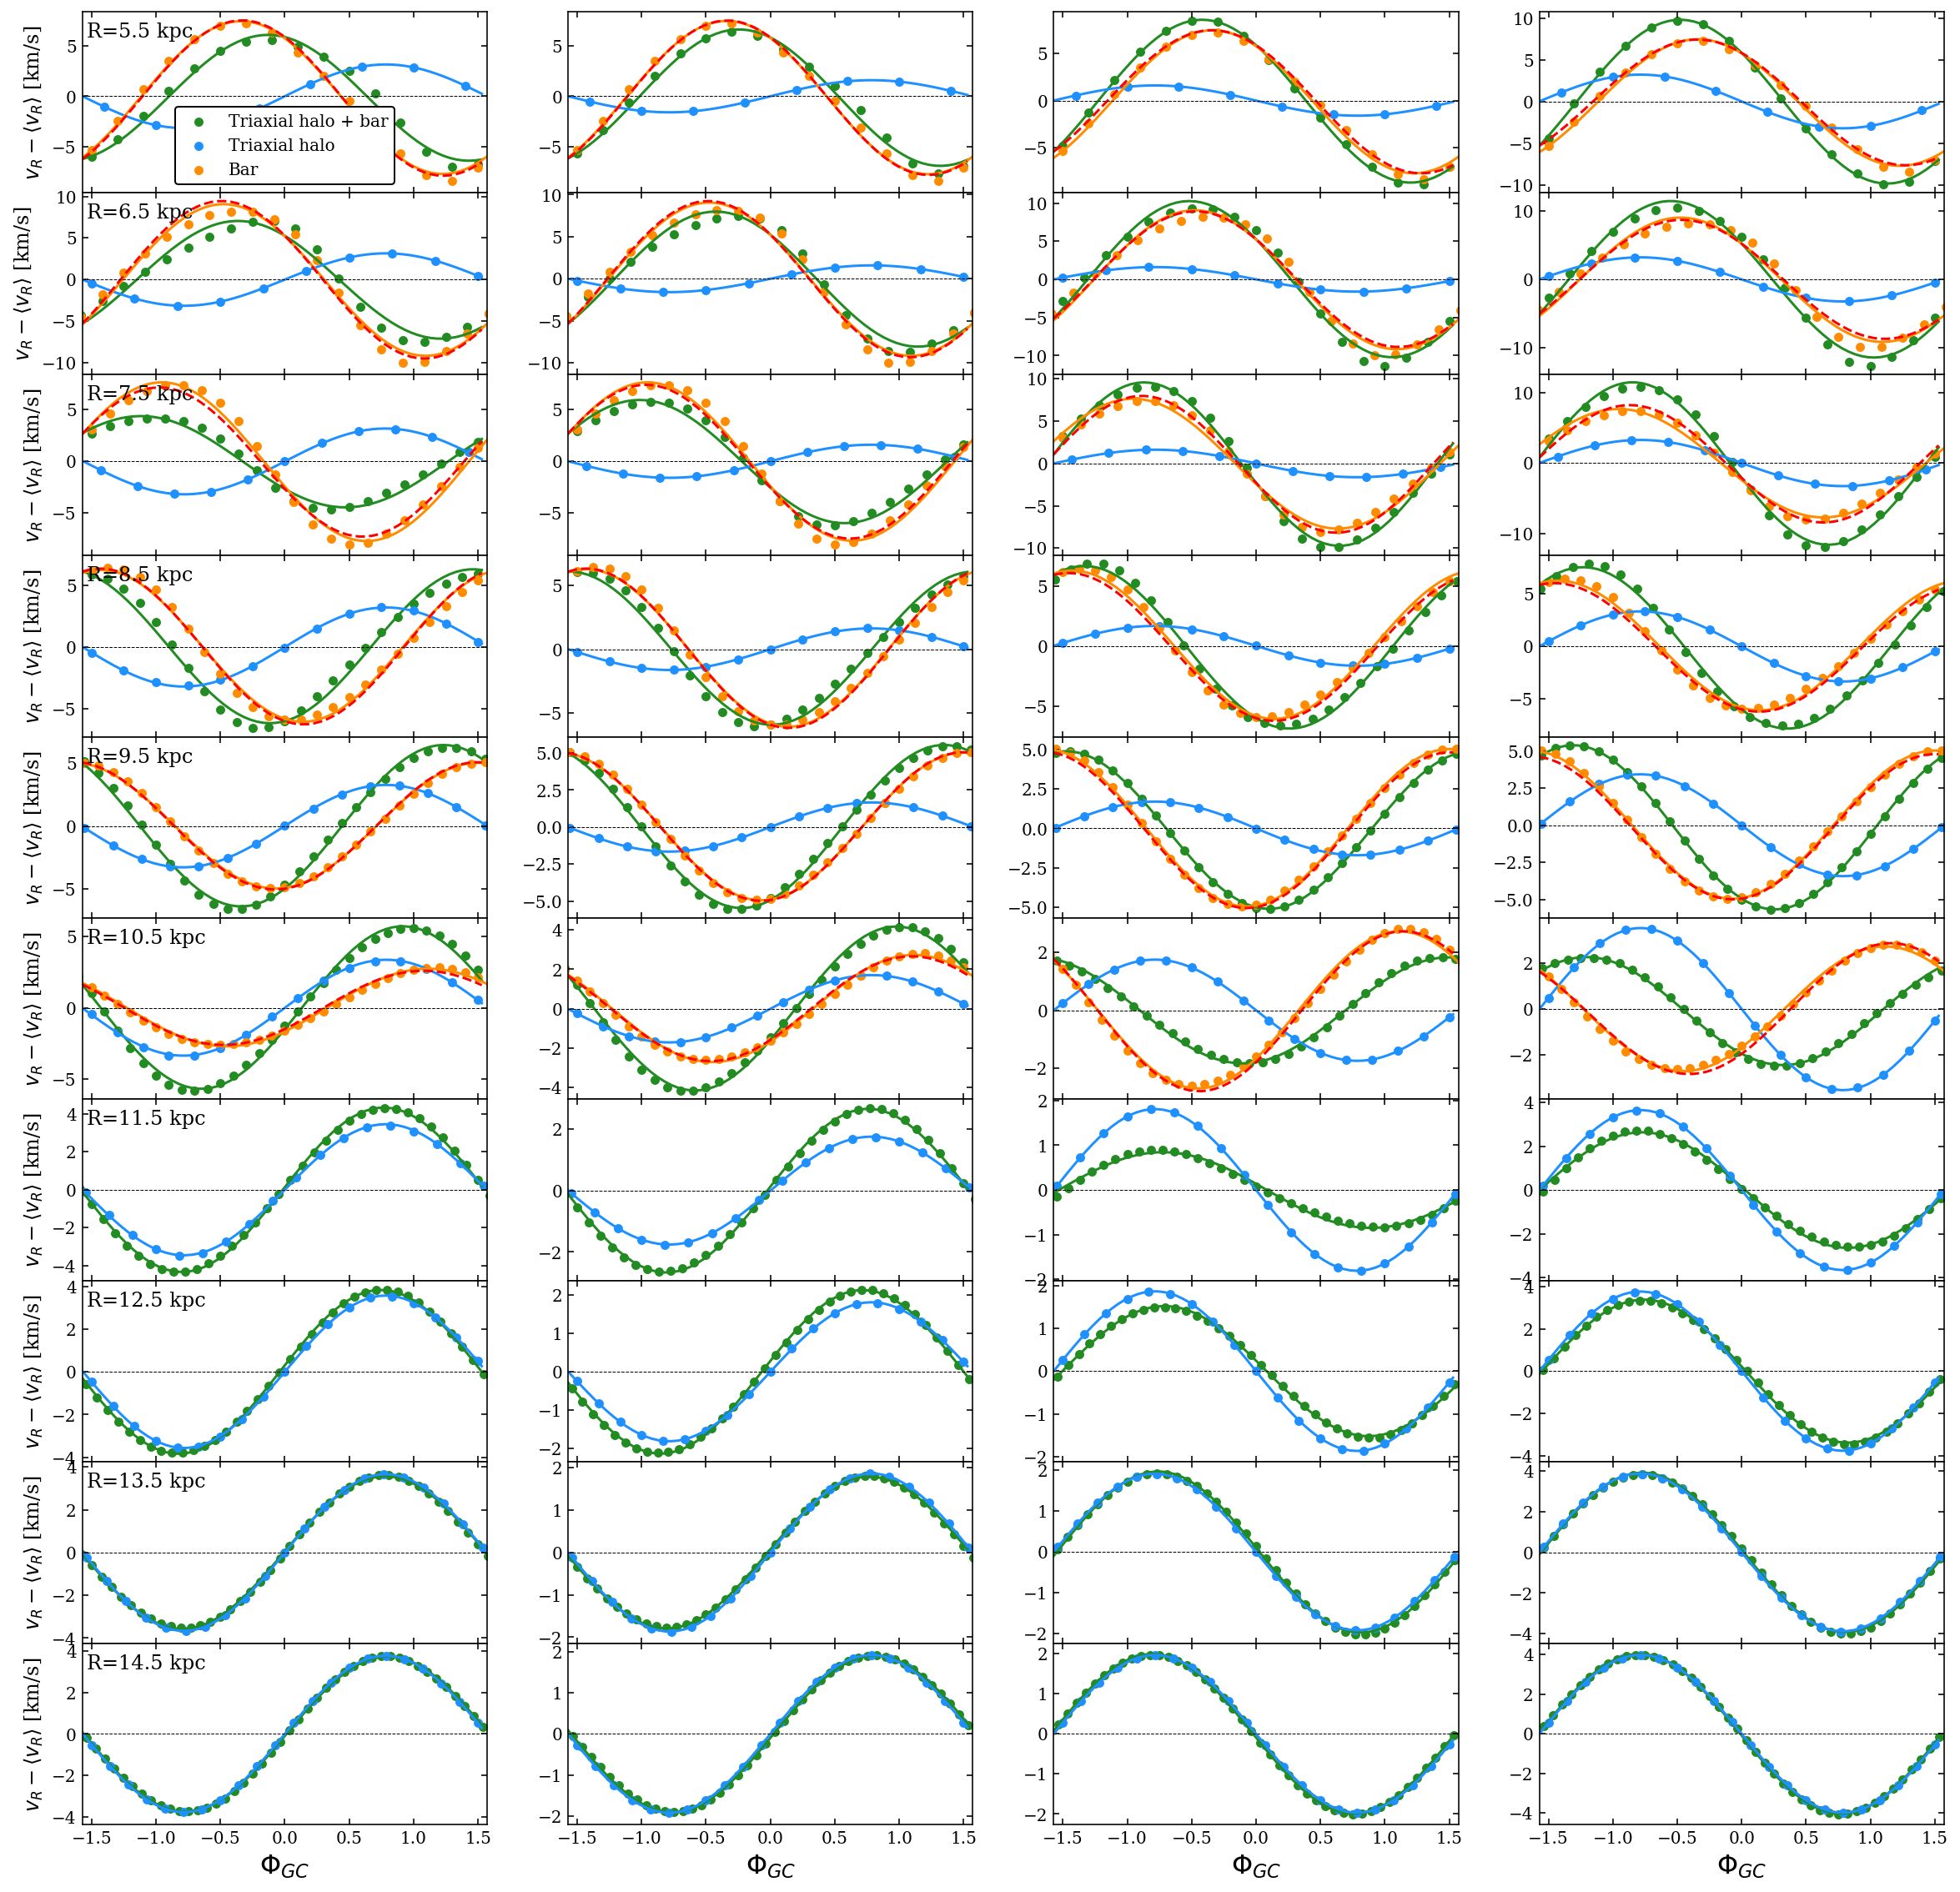

In [81]:
# Make the figure. 4 columns of axes, one for each radial bin.
fig = plt.figure( figsize=(20,int(n_R*2) ) )
axs = fig.subplots( nrows=n_R, ncols=4 )

# Now loop over each b value
for i in range( n_files ):
    
    # Load the data
    sim_bar_data = np.load( bar_files[i] ).astype(float)
    sim_halo_data = np.load( trihalo_files[i] ).astype(float)
    
    # Loop over each radial bin
    for j in range( n_R ):
        
        # Load data
        where_current_R_bar = np.where( sim_bar_data[:,0] == R_range[j] )[0]
        where_current_R_halo = np.where( sim_halo_data[:,0] == R_range[j] )[0]
        
        # Get the velocity and angle
        sim_bar_v = sim_bar_data[ where_current_R_bar, 4 ]
        sim_bar_v -= np.mean(sim_bar_v)
        sim_bar_phi = sim_bar_data[ where_current_R_bar, 1 ]
        sim_halo_v = sim_halo_data[ where_current_R_halo, 4 ]
        sim_halo_v -= np.mean(sim_halo_v)
        sim_halo_phi = sim_halo_data[ where_current_R_halo, 1 ]
        
        # Plot the data
        axs[j,i].scatter(sim_bar_phi, sim_bar_v, color='ForestGreen', marker='o', 
                         label=bar_label, s=20)
        axs[j,i].scatter(sim_halo_phi, sim_halo_v, color='DodgerBlue', marker='o', 
                         label=trihalo_label, s=20)
        
        # Plot the cosine fit to the data
        popt_bar,_ = curve_fit(sinusoid, sim_bar_phi, sim_bar_v, p0=[10,2.,0.0,0], ftol=0.01)
        fit_phi_bar = np.arange(-np.pi/2,np.pi/2,0.05)
        popt_halo,_ = curve_fit(sinusoid, sim_halo_phi, sim_halo_v, p0=[10,2.,0.0,0], ftol=0.01)
        fit_phi_halo = np.arange(-np.pi/2,np.pi/2,0.05)
        
        axs[j,i].plot( fit_phi_bar, sinusoid(fit_phi_bar, *popt_bar), color='ForestGreen', linestyle='solid' )
        axs[j,i].plot( fit_phi_halo, sinusoid(fit_phi_halo, *popt_halo), color='DodgerBlue', linestyle='solid')
        
        # Load bar only data
        where_current_R_bar_only = np.where( sim_bar_only_data[:,0] == R_range[j] )[0]
        if len(where_current_R_bar_only) > 0:
            sim_bar_only_v = sim_bar_only_data[ where_current_R_bar_only, 4 ]
            sim_bar_only_v -= np.mean(sim_bar_only_v)
            sim_bar_only_phi = sim_bar_only_data[ where_current_R_bar_only, 1 ]
            axs[j,i].scatter(sim_bar_only_phi, sim_bar_only_v, color='DarkOrange', marker='o', 
                             label='Bar', s=20)
            popt_bar_only,_ = curve_fit(sinusoid, sim_bar_only_phi, sim_bar_only_v, p0=[10,2.,0.0,0], ftol=0.01)
            fit_phi_bar_only = np.arange(-np.pi,np.pi,0.025)
            axs[j,i].plot(fit_phi_bar_only, sinusoid(fit_phi_bar_only, *popt_bar_only), 
                          color='DarkOrange', linestyle='solid' )
            
            # Take the difference between the triaxial halo + bar and triaxial halo
            axs[j,i].plot(fit_phi_bar, sinusoid(fit_phi_bar, *popt_bar)-sinusoid(fit_phi_halo, *popt_halo), 
                          color='Red', linestyle='dashed' )
        ##fi
        
        # Decorate
        axs[j,i].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
        axs[j,i].set_xlim(-np.pi/2,np.pi/2)
        
        if i == 0:
            axs[j,i].annotate(r'R='+str(R_range[j])+' kpc', (0.01,0.86), xycoords='axes fraction', fontsize=12)
            axs[j,i].set_ylabel(r'$v_{R} - \langle {v_{R}} \rangle$ [km/s]', fontsize=12)
        ##fi
        
        if j < n_R-1:
            axs[j,i].tick_params(labelbottom='off')
        ##fi
    ###j
    
    # Final decorate
    if i == 0:
        axs[0,i].legend(loc='lower center')
    
    axs[-1,i].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    fig.subplots_adjust(hspace=0)

###i

fig.subplots_adjust(hspace=0)

plt.show()
pass;